In [1]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from dotenv import load_dotenv

# Настройки отображения
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

# Загрузка переменных окружения
load_dotenv()
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Создание папки для графиков
os.makedirs('./charts', exist_ok=True)

In [2]:
# Загрузка данных с API
endpoints = ['visits', 'registrations', 'ads']

visits_api = None
regs_api = None
ads_api = None

for endpoint in endpoints:
    response = requests.get(f"{API_URL}/{endpoint}", params={
        'begin': DATE_BEGIN,
        'end': DATE_END
    })
    data = response.json()

    if endpoint == 'visits':
        visits_api = data
    elif endpoint == 'registrations':
        regs_api = data
    elif endpoint == 'ads':
        ads_api = data

In [3]:
# Преобразование API-данных в DataFrame
visits_data = pd.DataFrame(visits_api)
regs_data = pd.DataFrame(regs_api)

# Первые строки
print("visits_api:")
print(visits_data.head())

print("\nregs_api:")
print(regs_data.head())

visits_api:
                               visit_id platform  \
0  1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1  f149f542-e935-4870-9734-6b4501eaf614      web   
2  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
3  19322fed-157c-49c6-b16e-2d5cabeb9592      web   
4  04762a22-3c9f-40c9-9ac9-6628c4381836      web   

                                          user_agent             datetime  
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T10:36:22  
1  Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...  2023-03-01T06:25:00  
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...  2023-03-01T10:26:13  
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...  2023-03-01T12:33:06  
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T01:38:35  

regs_api:
              datetime                               user_id  \
0  2023-03-01T07:40:13  2e0f6bb8-b029-4f45-a786-2b53990d37f1   
1  2023-03-01T13:14:00  f007f97c-9d8b-48b5-af08-119bb8f6d9b6   
2  2023-03-01T03

In [4]:
# Удаляем ботов по user_agent
visits_data = visits_data[~visits_data['user_agent'].str.contains('bot', case=False, na=False)]

# Преобразование столбцов и даты
visits_data['datetime'] = pd.to_datetime(visits_data['datetime'])
regs_data['datetime'] = pd.to_datetime(regs_data['datetime'])

ads = pd.read_csv('./ads.csv')

# Столбец с датой
visits_data['date_group'] = visits_data['datetime'].dt.date
visits_data = visits_data.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset='visit_id', keep='last')
regs_data['date_group'] = regs_data['datetime'].dt.date
regs_data = regs_data.drop_duplicates()
ads['date_group'] = pd.to_datetime(ads['date']).dt.date

# изиты по дате и платформе
visits_daily = visits_data.groupby(['date_group', 'platform']) \
    .agg(visits=('visit_id', 'count')) \
    .reset_index()

# регистрации по дате и платформе
regs_daily = regs_data.groupby(['date_group', 'platform']) \
    .agg(registrations=('user_id', 'count')) \
    .reset_index()

# два датафрейма
conversion = pd.merge(visits_daily, regs_daily, on=['date_group', 'platform'], how='left')

# Заполнение пропусков и вычисление конверсии
conversion['registrations'] = conversion['registrations'].fillna(0)
conversion['conversion'] = (conversion['registrations'] / conversion['visits']) * 100

# Сортировка по дате
conversion = conversion.sort_values('date_group')
conversion.to_json('conversion.json')

In [5]:
# Загрузка рекламных данных
ads = pd.read_csv('./ads.csv')

# Преобразование дат
ads['date_group'] = pd.to_datetime(ads['date']).dt.date

# Общие затраты по дате и кампании
ads_by_date = ads.groupby(['date_group', 'utm_campaign']) \
    .agg(cost=('cost', 'sum')) \
    .reset_index()

# Объединение с конверсией
ads_merged = pd.merge(conversion, ads_by_date, on='date_group', how='left')

# пропуски
ads_merged['utm_campaign'] = ads_merged['utm_campaign'].fillna('none')
ads_merged['cost'] = ads_merged['cost'].fillna(0)

# Сохраняем в JSON
ads_merged.to_json('ads.json')

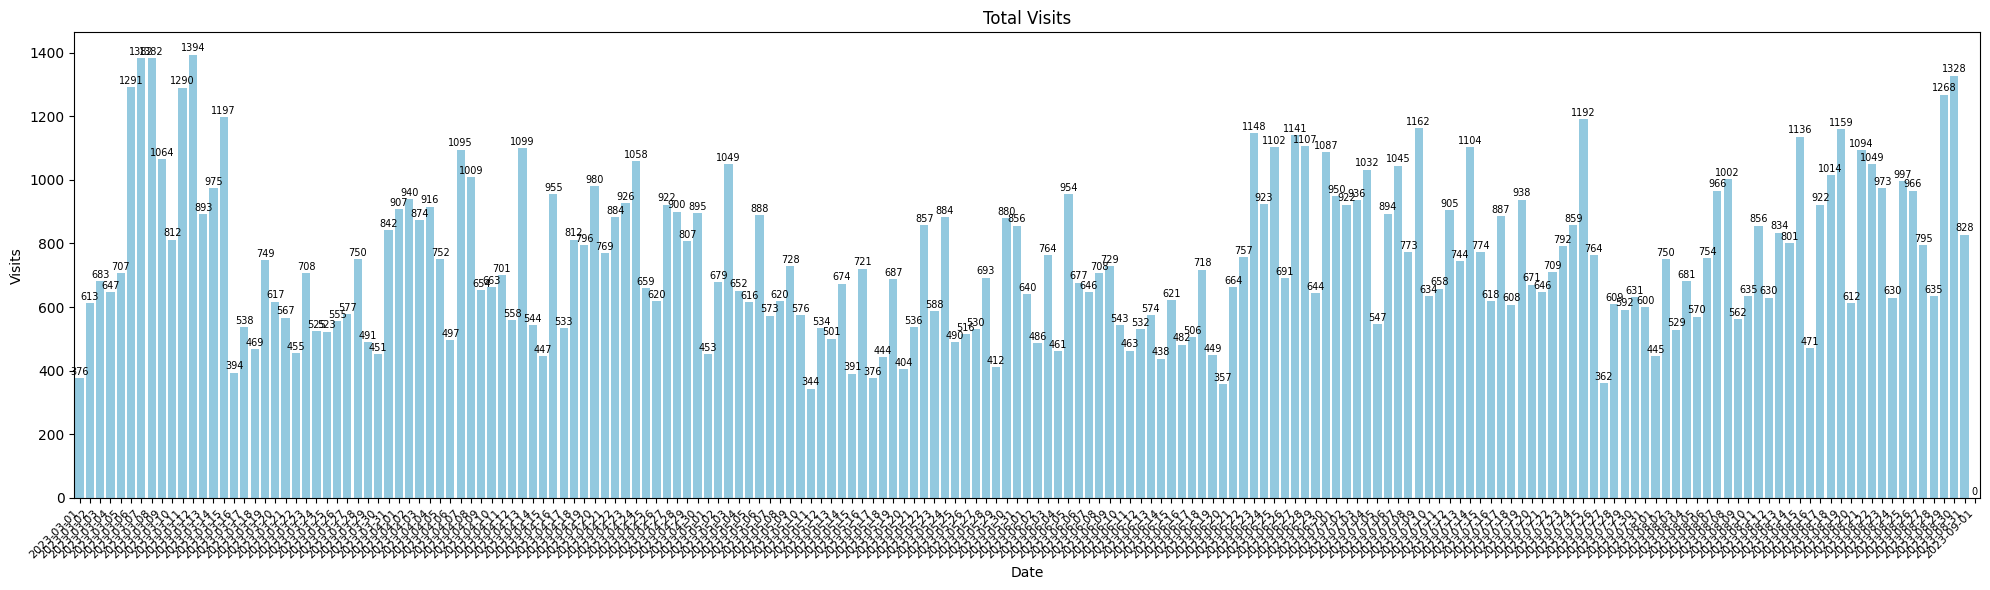

In [6]:
# Первый график: итоговые визиты

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

# правильный тип даты
ads_merged['date_group'] = pd.to_datetime(ads_merged['date_group'])

# Фильтрация по диапазону дат
start_date = pd.to_datetime(os.getenv("DATE_BEGIN"))
end_date = pd.to_datetime(os.getenv("DATE_END"))
filtered_data = ads_merged[
    (ads_merged['date_group'] >= start_date) &
    (ads_merged['date_group'] <= end_date)
]

# Группировка
total_visits = filtered_data.groupby('date_group', as_index=False)['visits'].sum()

# Добавление пропущенных дат
date_range = pd.date_range(start=start_date, end=end_date)
total_visits = total_visits.set_index('date_group').reindex(date_range, fill_value=0).reset_index()
total_visits = total_visits.rename(columns={'index': 'date_group'})

# График
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=total_visits, x='date_group', y='visits', color='skyblue')
ax.set_xticks(range(len(total_visits)))
ax.set_xticklabels(total_visits['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=8)

# Подписи над столбиками
for i, row in total_visits.iterrows():
    ax.text(x=i, y=row['visits'] + 10, s=f"{int(row['visits'])}", ha='center', fontsize=7)

# Подписи и сохранение
plt.title("Total Visits")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.tight_layout()
plt.savefig('./charts/total_visits.png')

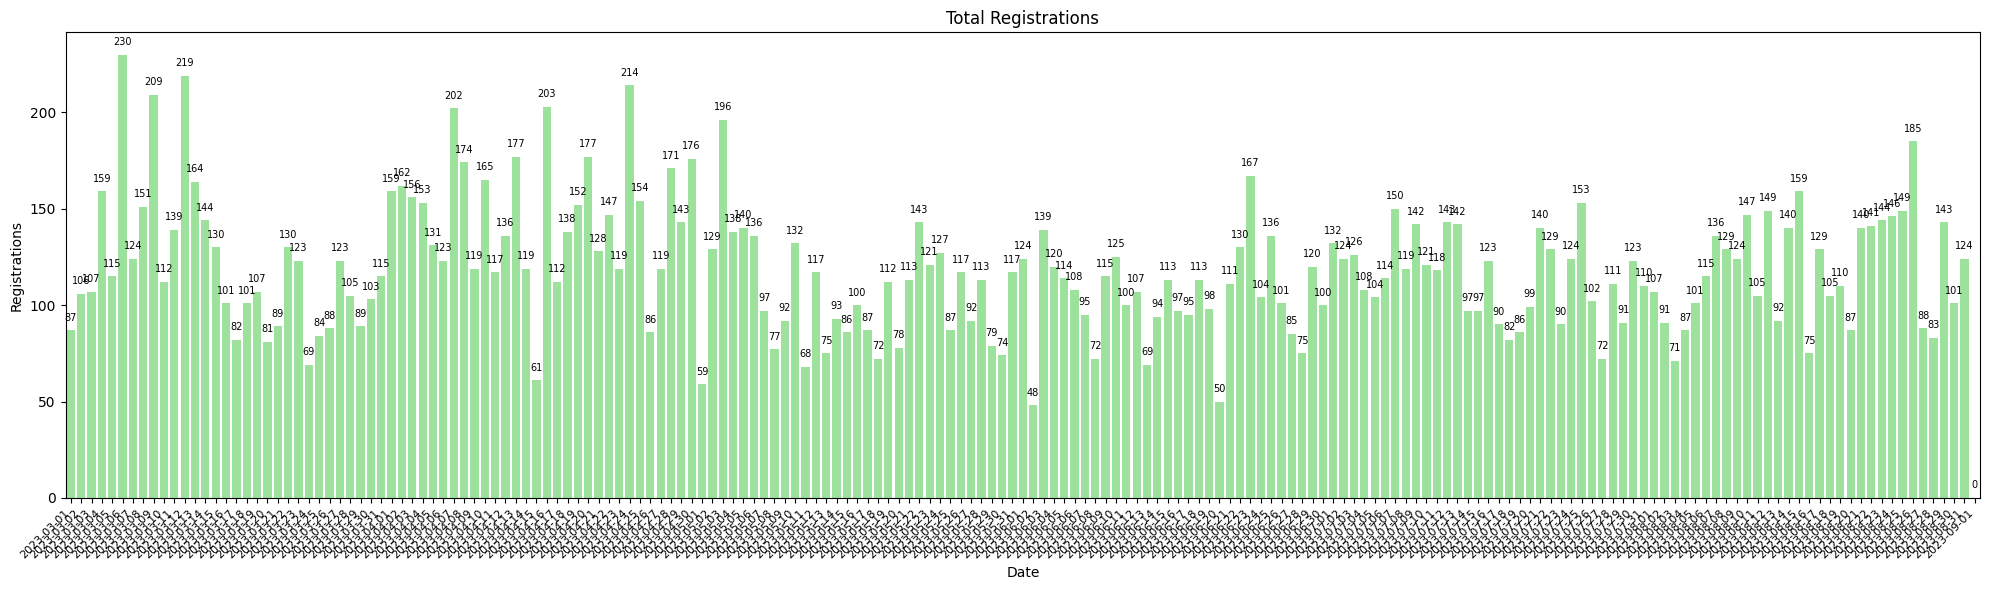

In [7]:
# Второй график: итоговые регистрации

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

# Фильтрация по нужному периоду
start_date = pd.to_datetime(os.getenv("DATE_BEGIN"))
end_date = pd.to_datetime(os.getenv("DATE_END"))
filtered_data = ads_merged[(ads_merged['date_group'] >= start_date) & (ads_merged['date_group'] <= end_date)]

# Группировка регистраций по дате
total_regs = filtered_data.groupby('date_group', as_index=False)['registrations'].sum()

# Добавление пропущенных дат
date_range = pd.date_range(start=start_date, end=end_date)
total_regs = total_regs.set_index('date_group').reindex(date_range, fill_value=0).reset_index()
total_regs = total_regs.rename(columns={'index': 'date_group'})

# График
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=total_regs, x='date_group', y='registrations', color='lightgreen')
ax.set_xticks(range(len(total_regs)))
ax.set_xticklabels(total_regs['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=8)

# Подписи над столбцами
for i, row in total_regs.iterrows():
    ax.text(x=i, y=row['registrations'] + 5, s=f"{int(row['registrations'])}", ha='center', fontsize=7)

# Подписи и сохранение
plt.title("Total Registrations")
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.tight_layout()
plt.savefig('./charts/total_registrations.png')

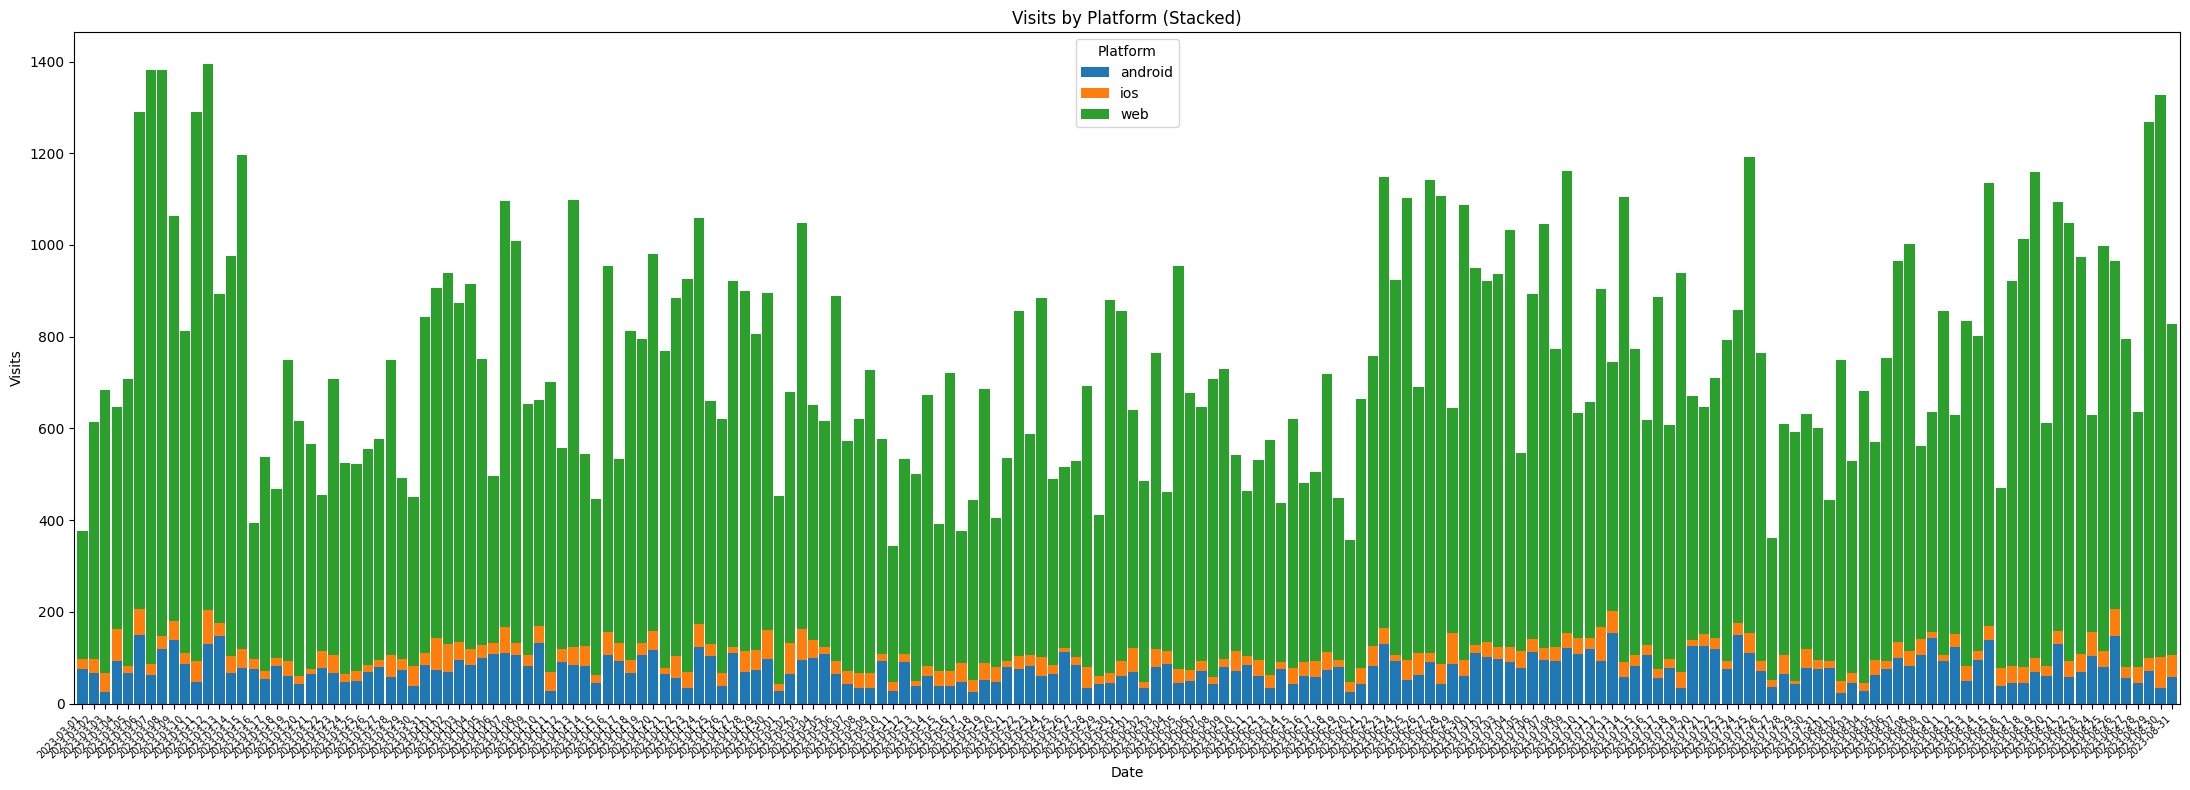

In [8]:
# Третий график: итоговые визиты с разбивкой по платформам

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

start_date = pd.to_datetime(os.getenv("DATE_BEGIN"))
end_date = pd.to_datetime(os.getenv("DATE_END"))
filtered_df = ads_merged[(ads_merged['date_group'] >= start_date) & (ads_merged['date_group'] <= end_date)]

# Получение списка всех платформ
all_platforms = filtered_df['platform'].unique()

# Группировка и поворот таблицы
visits_by_platform = filtered_df.groupby(['date_group', 'platform'], as_index=False)['visits'].sum()
pivot_df = visits_by_platform.pivot(index='date_group', columns='platform', values='visits').fillna(0)

# Добавление отсутствующих столбцов платформ
for platform in all_platforms:
    if platform not in pivot_df.columns:
        pivot_df[platform] = 0

# Построение графика
fig, ax = plt.subplots(figsize=(22, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax, width=0.9)

# Настройка осей
ax.set_title("Visits by Platform (Stacked)")
ax.set_xlabel("Date")
ax.set_ylabel("Visits")

# Подписи по X по всем дням
ax.set_xticks(range(len(pivot_df.index)))
ax.set_xticklabels(pivot_df.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=7)

# Легенда
ax.legend(title="Platform")

# Сохранение
plt.tight_layout()
plt.savefig('./charts/visits_by_platform_stacked.png')

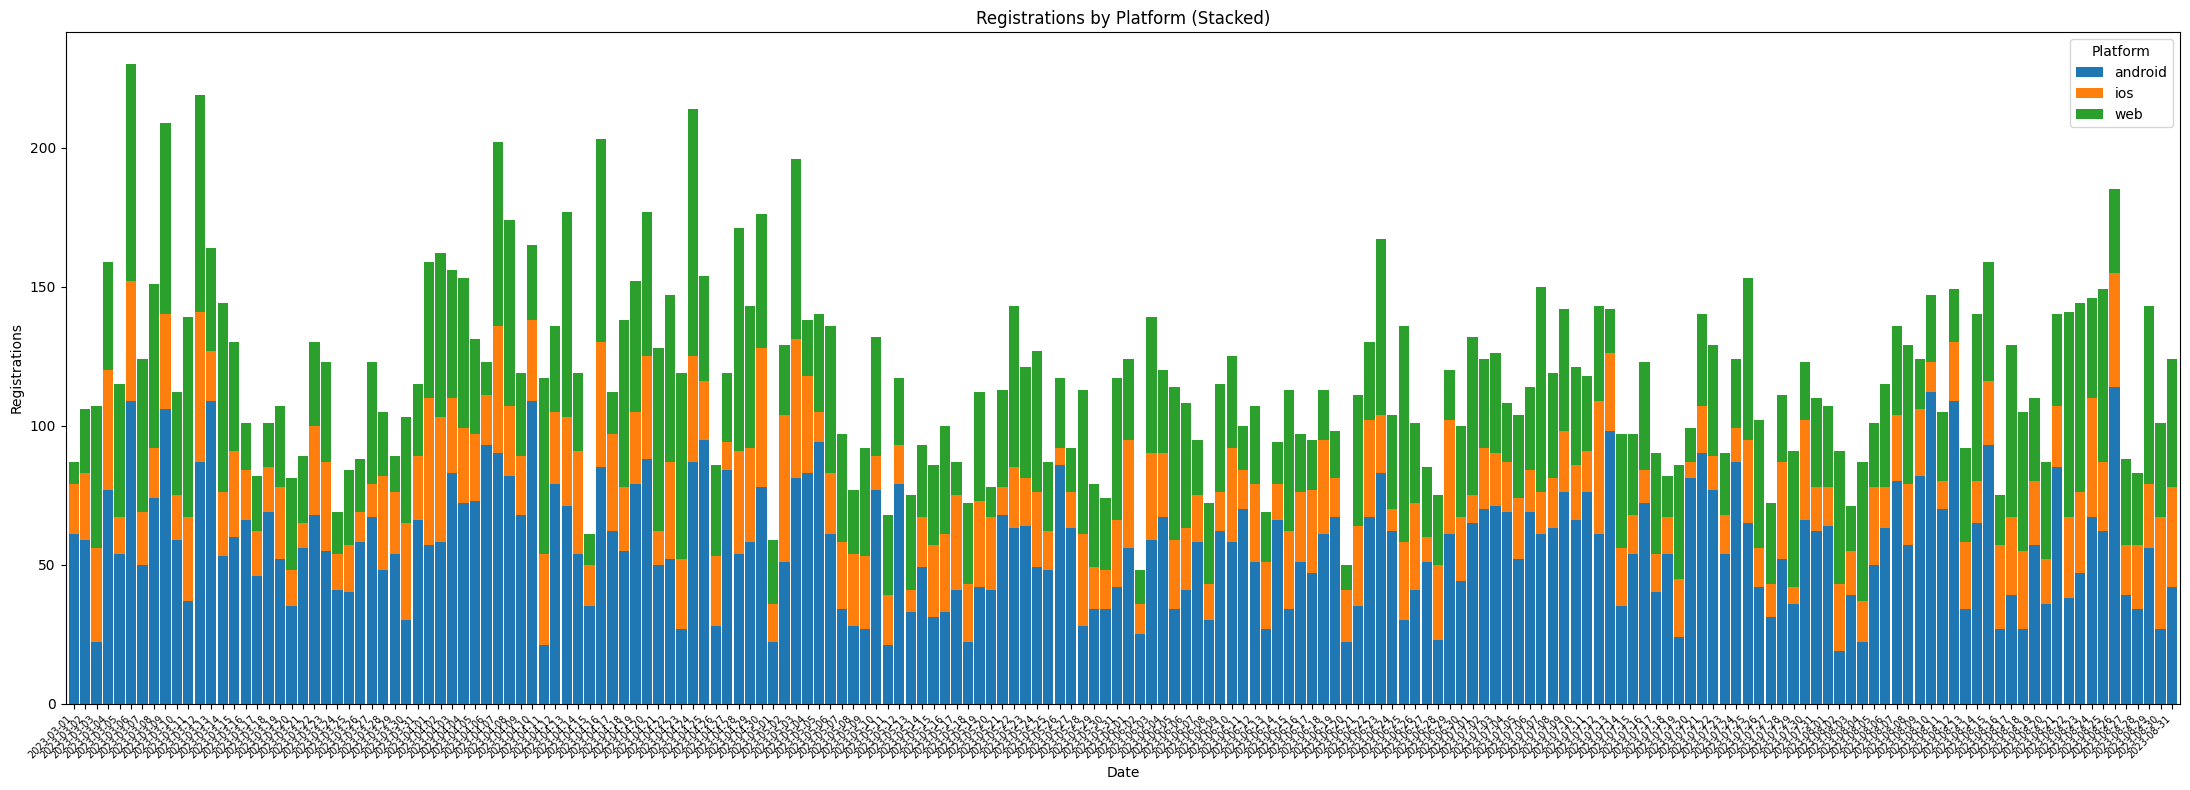

In [9]:
# Четвертый график: итоговые регистрации с разбивкой по платформе

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

# Используем уже готовый датафрейм ads_merged
conversion_df = ads_merged.copy()

# Фильтрация по нужному диапазону
start_date = pd.to_datetime(DATE_BEGIN)
end_date = pd.to_datetime(DATE_END)
conversion_df = conversion_df[(conversion_df['date_group'] >= start_date) & (conversion_df['date_group'] <= end_date)]

# Группировка и поворот
regs_by_platform = conversion_df.groupby(['date_group', 'platform'], as_index=False)['registrations'].sum()
pivot_df = regs_by_platform.pivot(index='date_group', columns='platform', values='registrations').fillna(0)

# Построение графика
fig, ax = plt.subplots(figsize=(22, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax, width=0.9)

# Настройка осей
ax.set_title("Registrations by Platform (Stacked)")
ax.set_xlabel("Date")
ax.set_ylabel("Registrations")
ax.set_xticks(range(len(pivot_df)))
ax.set_xticklabels(pivot_df.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=7)

# Легенда
ax.legend(title="Platform")

# Сохранение
plt.tight_layout()
plt.savefig('./charts/registrations_by_platform_stacked.png')

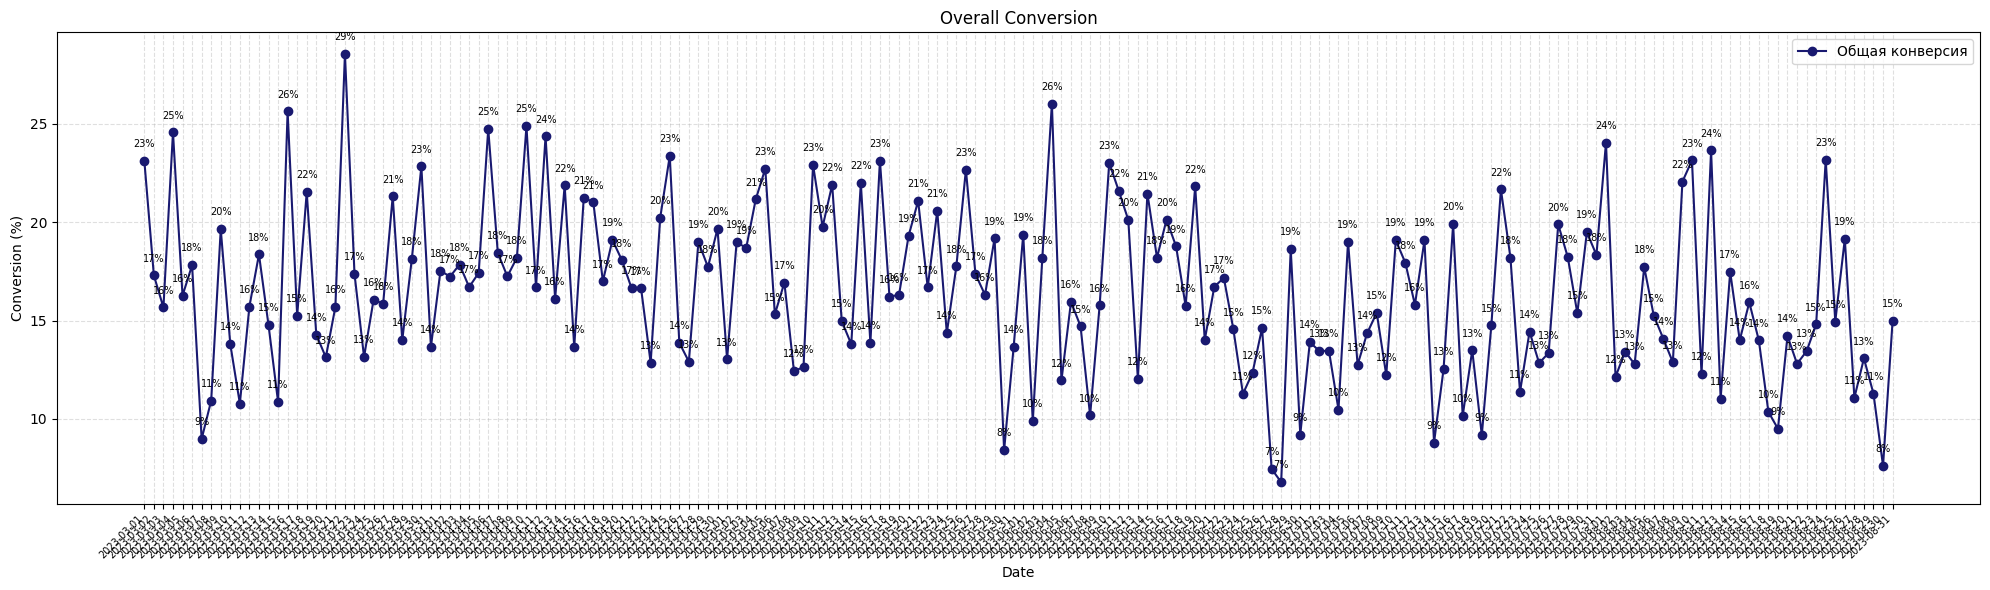

In [10]:
# Пятый график: итоговые конверсии

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)
conversion_df = ads_merged.copy()

# Фильтрация по диапазону
start_date = pd.to_datetime(DATE_BEGIN)
end_date = pd.to_datetime(DATE_END)
filtered_df = conversion_df[(conversion_df['date_group'] >= start_date) & (conversion_df['date_group'] <= end_date)]

# Группировка и расчет конверсии
daily = filtered_df.groupby('date_group', as_index=False)[['visits', 'registrations']].sum()
daily['conversion'] = (daily['registrations'] / daily['visits']) * 100

# Построение графика
plt.figure(figsize=(20, 6))
ax = plt.gca()
ax.plot(daily['date_group'], daily['conversion'], marker='o', label='Общая конверсия', color='midnightblue')

# Подписи над точками
for i, row in daily.iterrows():
    ax.text(x=row['date_group'], y=row['conversion'] + 0.7,
            s=f"{int(round(row['conversion'], 0))}%", ha='center', fontsize=7)

# Оформление осей
ax.set_title("Overall Conversion")
ax.set_xlabel("Date")
ax.set_ylabel("Conversion (%)")
ax.set_xticks(daily['date_group'])
ax.set_xticklabels(daily['date_group'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=7)

# Остальное оформление
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')

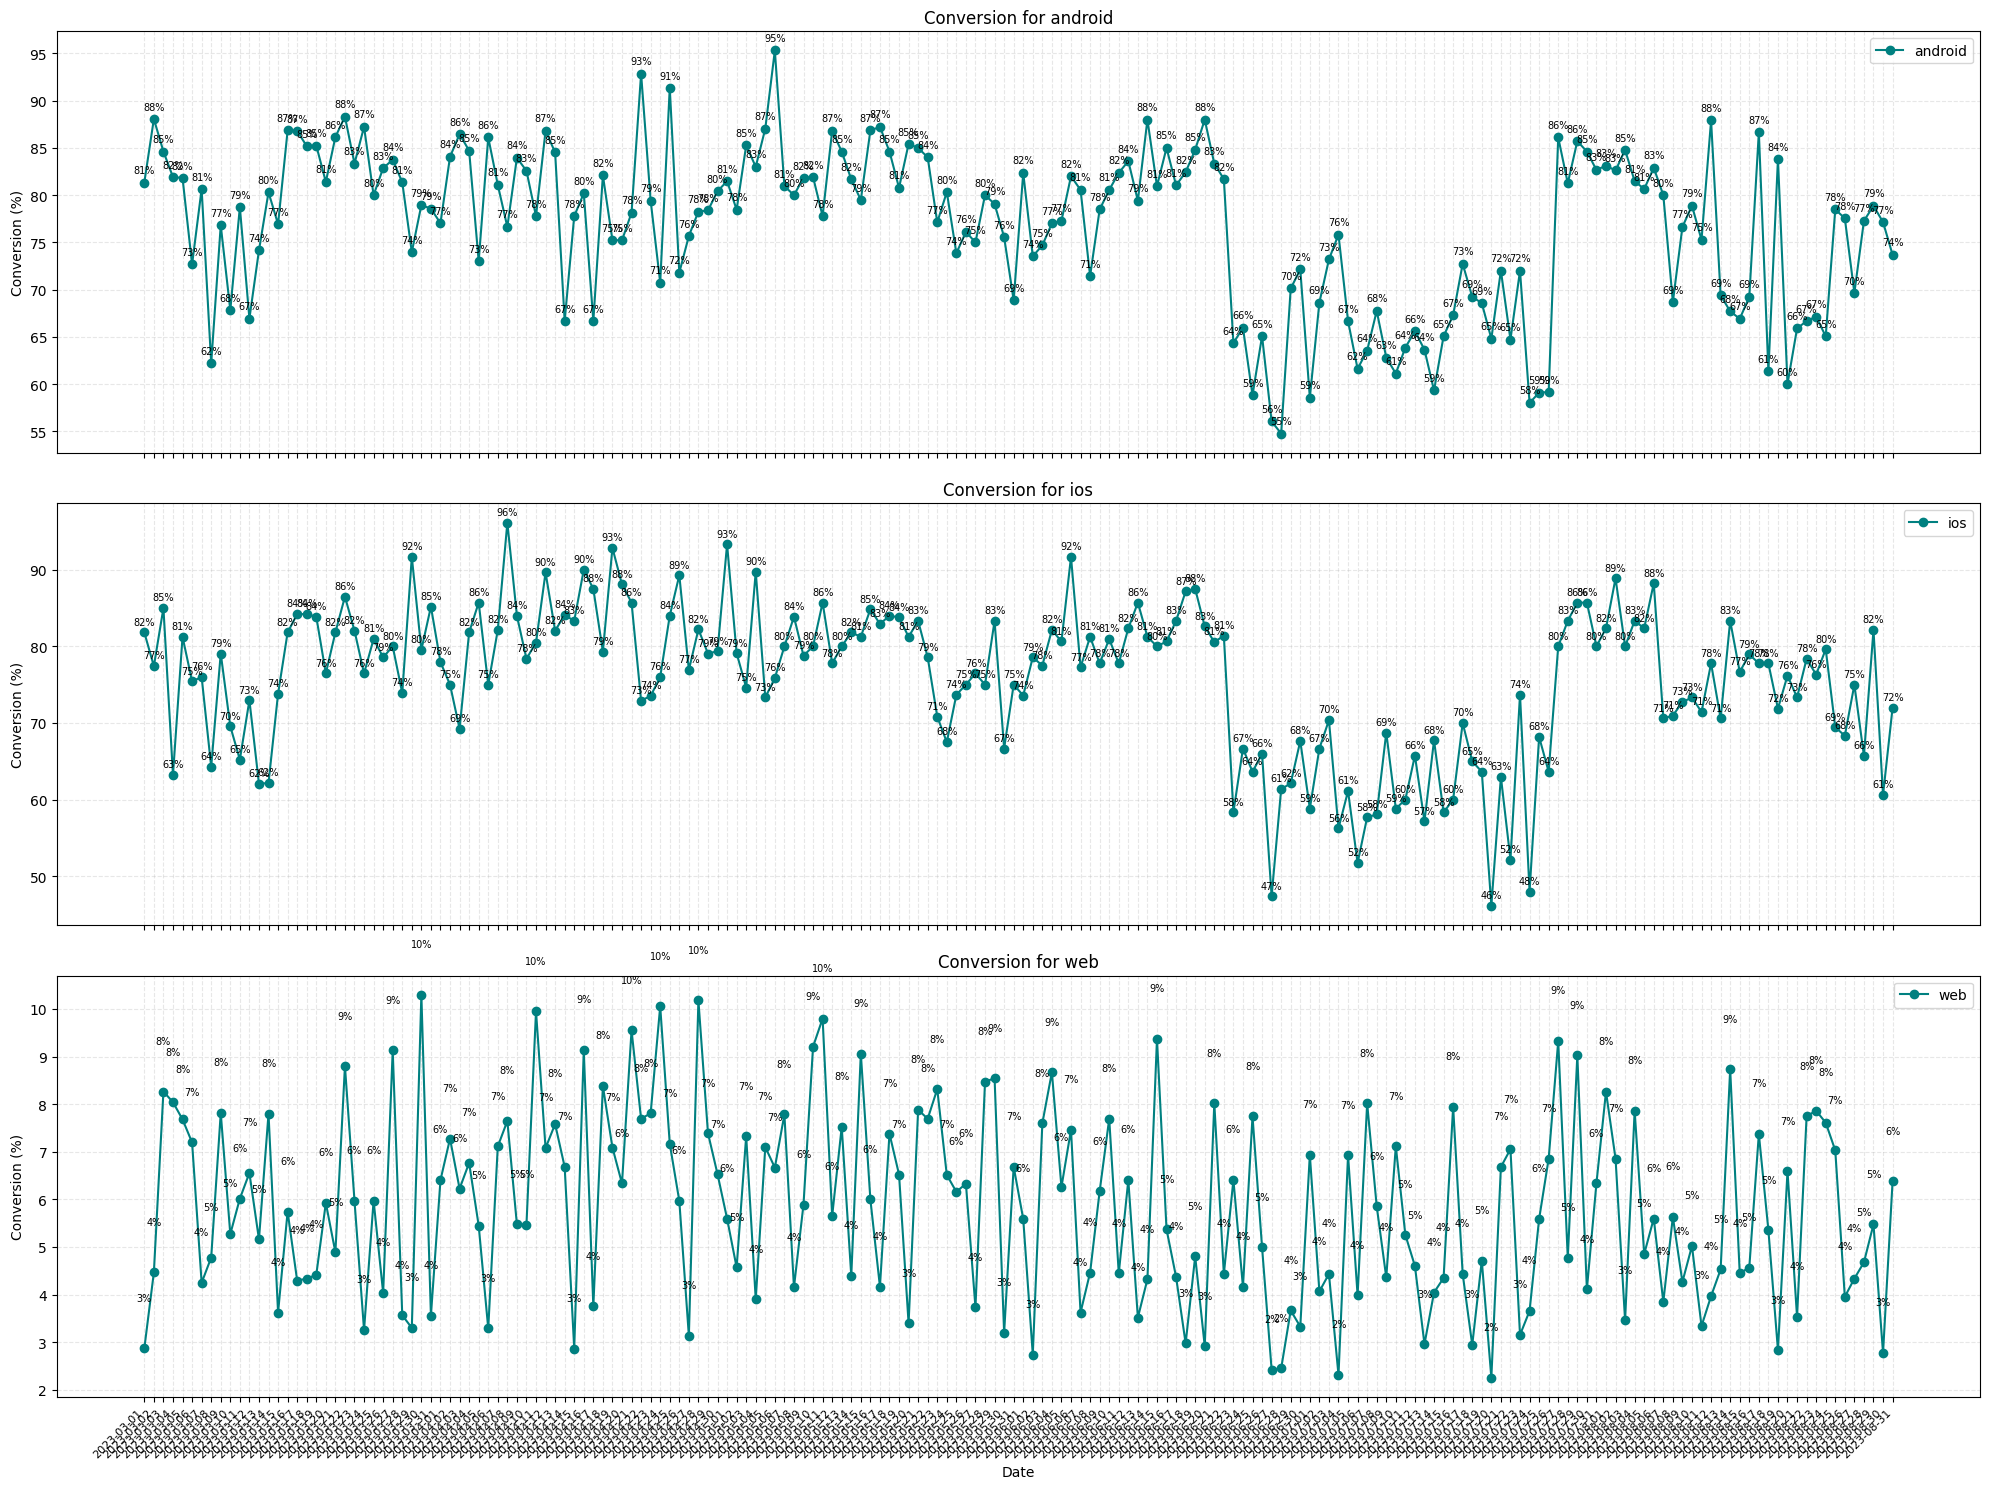

In [11]:
# Шестой график: конверсия по каждой платформе

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)
conversion_df = ads_merged.copy()

# Фильтрация по диапазону дат
start_date = pd.to_datetime(DATE_BEGIN)
end_date = pd.to_datetime(DATE_END)
filtered_df = conversion_df[(conversion_df['date_group'] >= start_date) & (conversion_df['date_group'] <= end_date)]

# Группировка и расчет конверсий
by_platform = filtered_df.groupby(['date_group', 'platform'], as_index=False)[['visits', 'registrations']].sum()
by_platform['conversion'] = (by_platform['registrations'] / by_platform['visits']) * 100

# Уникальные платформы
platforms = by_platform['platform'].unique()

# Готовим графики
fig, axs = plt.subplots(len(platforms), 1, figsize=(20, 5 * len(platforms)), sharex=True)

# Построение графика по каждой платформе
for i, platform in enumerate(platforms):
    df = by_platform[by_platform['platform'] == platform]
    axs[i].plot(df['date_group'], df['conversion'], marker='o', label=platform, color='teal')

    for _, row in df.iterrows():
        axs[i].text(x=row['date_group'],
                    y=row['conversion'] + 1,
                    s=f"{int(round(row['conversion'], 0))}%",
                    ha='center', fontsize=7)

    axs[i].set_title(f"Conversion for {platform}", fontsize=12)
    axs[i].set_ylabel("Conversion (%)")
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.3)

# Настройка общей оси X
xtick_dates = sorted(by_platform['date_group'].unique())
axs[-1].set_xlabel("Date")
axs[-1].set_xticks(xtick_dates)
axs[-1].set_xticklabels(pd.Series(xtick_dates).dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=8)

# Сохранение
plt.tight_layout()
plt.savefig('./charts/conversion_by_platform.png')

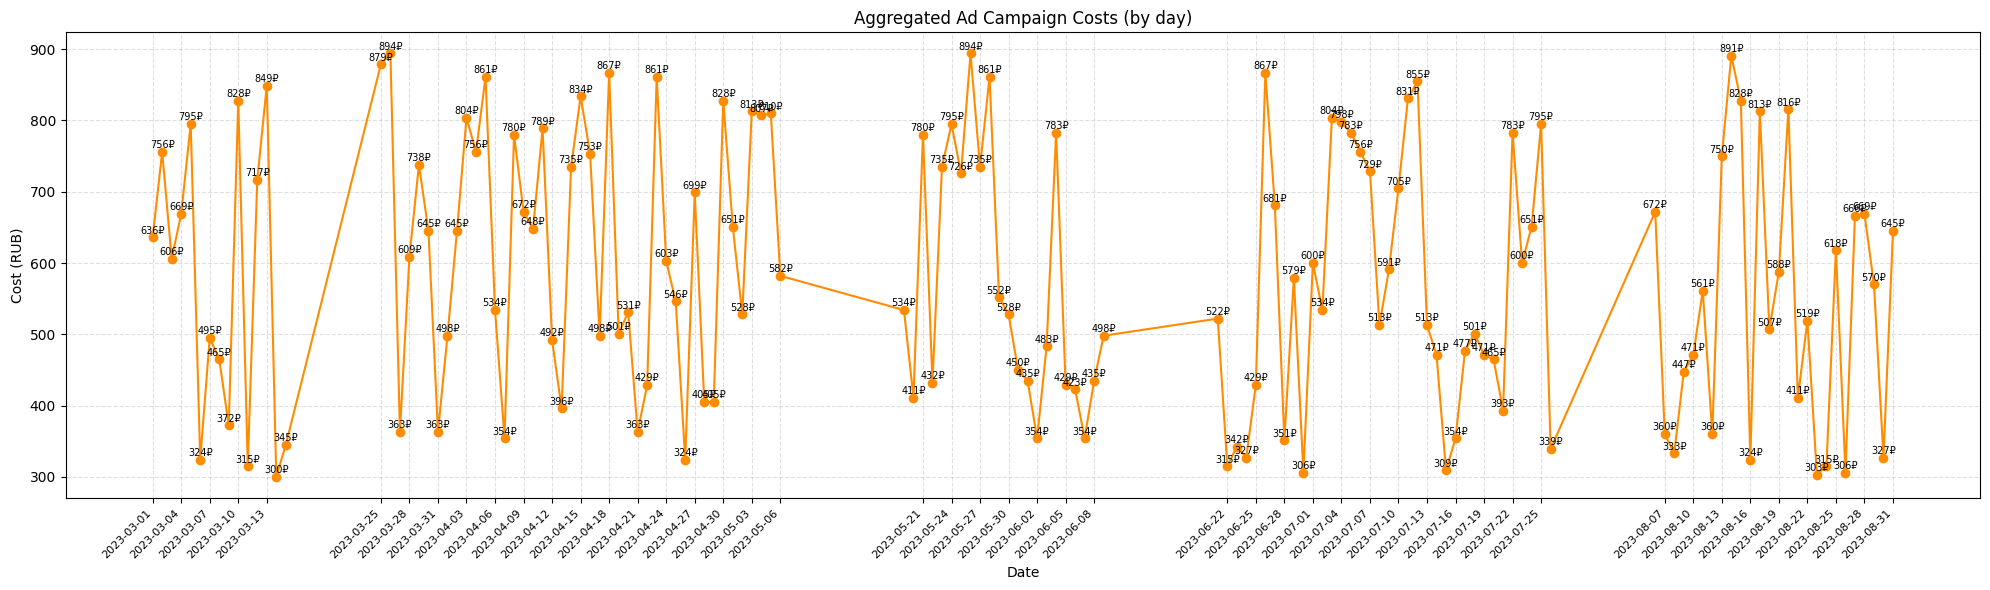

In [12]:
# Седьмой график: стоимость рекламы

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

# Преобразование и фильтрация
ads_merged['date_group'] = pd.to_datetime(ads_merged['date_group'])
start_date = pd.to_datetime(DATE_BEGIN)
end_date = pd.to_datetime(DATE_END)
filtered_df = ads_merged[(ads_merged['date_group'] >= start_date) & (ads_merged['date_group'] <= end_date)]

# Группировка и удаление нулевых значений
daily_cost = filtered_df.groupby('date_group', as_index=False)['cost'].sum()
daily_cost = daily_cost[daily_cost['cost'] > 0].sort_values('date_group')

# Построение графика
plt.figure(figsize=(20, 6))
plt.plot(daily_cost['date_group'], daily_cost['cost'], marker='o', linestyle='-', color='darkorange')

# Подписи значений
for i, row in daily_cost.iterrows():
    plt.text(x=row['date_group'],
             y=row['cost'] + 5,
             s=f"{int(row['cost'])}₽",
             ha='center',
             fontsize=7)

# Настройка осей
plt.title("Aggregated Ad Campaign Costs (by day)")
plt.xlabel("Date")
plt.ylabel("Cost (RUB)")
plt.grid(True, linestyle='--', alpha=0.4)

# Установка xticks с интервалом
xticks = range(0, len(daily_cost), 3)
xticklabels = [date.strftime('%Y-%m-%d') for date in daily_cost['date_group'].iloc[xticks]]
plt.xticks(ticks=daily_cost['date_group'].iloc[xticks], labels=xticklabels, rotation=45, ha='right', fontsize=8)

# Сохранение
plt.tight_layout()
plt.savefig('./charts/ads_cost_by_platform.png')

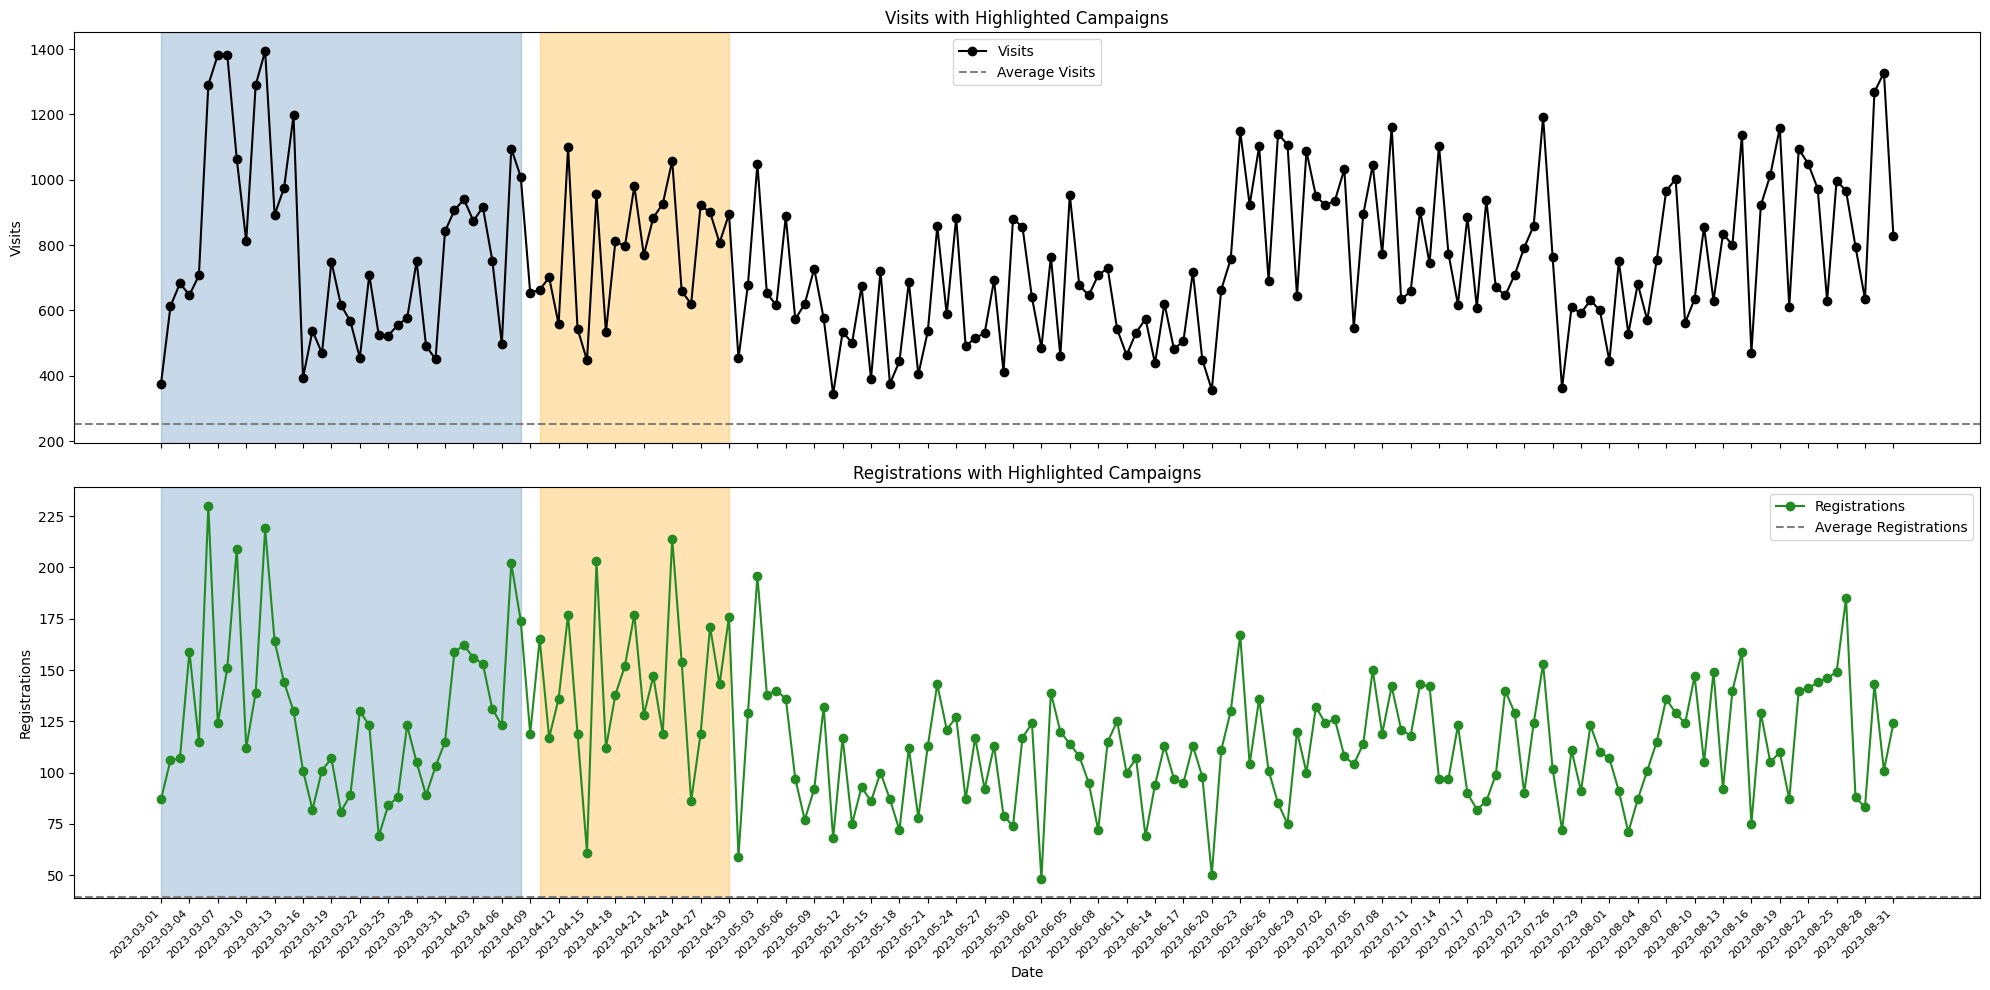

In [13]:
# Восьмой график: визиты и регистрации с выделением рекламных кампаний

import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('./charts', exist_ok=True)

# Приведение даты и фильтрация по периоду
ads_merged['date_group'] = pd.to_datetime(ads_merged['date_group'])
start_date = pd.to_datetime(DATE_BEGIN)
end_date = pd.to_datetime(DATE_END)
filtered_df = ads_merged[(ads_merged['date_group'] >= start_date) & (ads_merged['date_group'] <= end_date)]

# Средние значения
avg_visits = filtered_df['visits'].mean()
avg_regs = filtered_df['registrations'].mean()

# Кампании
campaigns = [
    {
        'name': 'google cpc virtual_reality_workshop',
        'start': '2023-04-10',
        'end': '2023-04-30',
        'color': 'orange'
    },
    {
        'name': 'tg social game_dev_crash_course',
        'start': '2023-03-01',
        'end': '2023-04-08',
        'color': 'steelblue'
    }
]

# Группировка
daily_stats = filtered_df.groupby('date_group', as_index=False)[['visits', 'registrations']].sum()

# Построение
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Первый график: визиты
ax1.plot(daily_stats['date_group'], daily_stats['visits'], marker='o', color='black', label='Visits')
ax1.axhline(avg_visits, linestyle='--', color='gray', label='Average Visits')

# Второй график: регистрации
ax2.plot(daily_stats['date_group'], daily_stats['registrations'], marker='o', color='forestgreen', label='Registrations')
ax2.axhline(avg_regs, linestyle='--', color='gray', label='Average Registrations')

# Кампании на фоне
for campaign in campaigns:
    for ax in [ax1, ax2]:
        ax.axvspan(pd.to_datetime(campaign['start']),
                   pd.to_datetime(campaign['end']),
                   color=campaign['color'], alpha=0.3)

# Настройка осей и подписей
ax1.set_ylabel("Visits")
ax1.set_title("Visits with Highlighted Campaigns")
ax1.legend()

ax2.set_ylabel("Registrations")
ax2.set_title("Registrations with Highlighted Campaigns")
ax2.legend()

plt.xlabel("Date")
tick_dates = daily_stats['date_group'].iloc[::3]
plt.xticks(ticks=tick_dates, labels=tick_dates.dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=8)

# Сохранение
plt.tight_layout()
plt.savefig('./charts/visits_and_regs_with_campaigns.png')